## Western or Sci-fi? Can deep learning tell a cowboy from an astronaut?

This is an exercise for Lesson 1 of the Fast.ai "Practical Deep Learning for Coders" course, based on the notebook [Is it a bird? Creating a model from your own data](https://www.kaggle.com/code/jhoward/is-it-a-bird-creating-a-model-from-your-own-data) by Jeremy Howard.

We’re going to train a deep neural network to classify the genre of a movie as either Western or Sci-fi, given a movie poster. Initially, I tried using only poster images for the training set, but I figured I would get better results if I used generic movie pictures

In [46]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai fastbook duckduckgo_search difPy

## Step 1: Download photos of western and sci-fi movies

Let's start by downloading some movie pictures using DuckDuckGo image search.

In [47]:
import fastbook
from fastbook import *

path = Path('categories')
print(path.resolve())

/kaggle/working/categories


In [51]:
# Clean the dataset if needed
if path.exists():
    shutil.rmtree(path)

In [52]:
def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(search_images_ddg(term, max_images))

def search_and_download_images(searches, max_images=100, max_size=600):
    for o in searches:
        dest = (path/o)
        dest.mkdir(exist_ok=True, parents=True)
        download_images(dest, urls=search_images(f'{o} movie photo', max_images))
        resize_images(path/o, max_size=max_size, dest=path/o)

In [53]:
search_and_download_images(['sci-fi', 'western'])

Searching for 'sci-fi movie photo'
Searching for 'western movie photo'


Let’s also download some test images that we’ll use for a later demo. Some of them are quite challenging.

In [54]:
download_url('https://a.1stdibscdn.com/unknown-prints-works-on-paper-large-original-vintage-sci-fi-movie-poster-for-terminator-arnold-schwarzenegger-for-sale/a_436/1547124219718/PC1203_master.jpg', 'test/terminator.jpg', show_progress=False)
download_url('https://image.tmdb.org/t/p/original/217ddlMrnXll436baw7y5ERmz3x.jpg', 'test/badland.jpg', show_progress=False)
download_url('https://image.tmdb.org/t/p/original/vUmpFXl8lgH4qyeLdaI2Xmw79UB.jpg', 'test/cowboys_aliens.jpg', show_progress=False)
download_url('https://i.etsystatic.com/20762201/r/il/a893b9/3202456262/il_fullxfull.3202456262_scdk.jpg', 'test/unforgiven.jpg', show_progress=False)
download_url('https://cdn.shopify.com/s/files/1/1057/4964/products/mad-max-vintage-movie-poster-original-40x60.jpg', 'test/mad-max.jpg', show_progress=False)
download_url('https://picfiles.alphacoders.com/349/thumb-1920-349599.jpg', 'test/interstellar.jpg', show_progress=False)
download_url('https://de.web.img3.acsta.net/pictures/24/02/20/15/10/1318924.jpg', 'test/horizon.jpg', show_progress=False)

Path('test/horizon.jpg')

## Step 2: Train our model

First let's cleanup our data. Some photos might not download correctly which could cause our model training to fail, so we'll remove them - `verify_images` checks if the image files can actually be opened:

In [55]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

19

The probability of getting the same poster twice on the dataset is non negligeble, and it may end on both test and validation sets, so to be safe(r) we're also checking for similar images using [difPy](https://github.com/elisemercury/Duplicate-Image-Finder). 

We're also trying to make sure that the images we're using to demo the model aren't part of the training set.

In [56]:
import difPy

dif = difPy.build([str((path/'sci-fi').resolve()), str((path/'western').resolve()), 'test'])
search = difPy.search(dif, similarity="similar")
print(search.result)
search.delete(silent_del=True)

difPy preparing files: [100%]
difPy searching files: [100%]
{}
Deleted 0 file(s)


We can now create the `DataLoaders` object that contains a *training set* and a *validation set*. Check out [Is it a bird? Creating a model from your own data](https://www.kaggle.com/code/jhoward/is-it-a-bird-creating-a-model-from-your-own-data) for an explanation of each of the parameters passed to `DataBlock`.

Let's also peek into the dataset by showing a batch of 32 images.

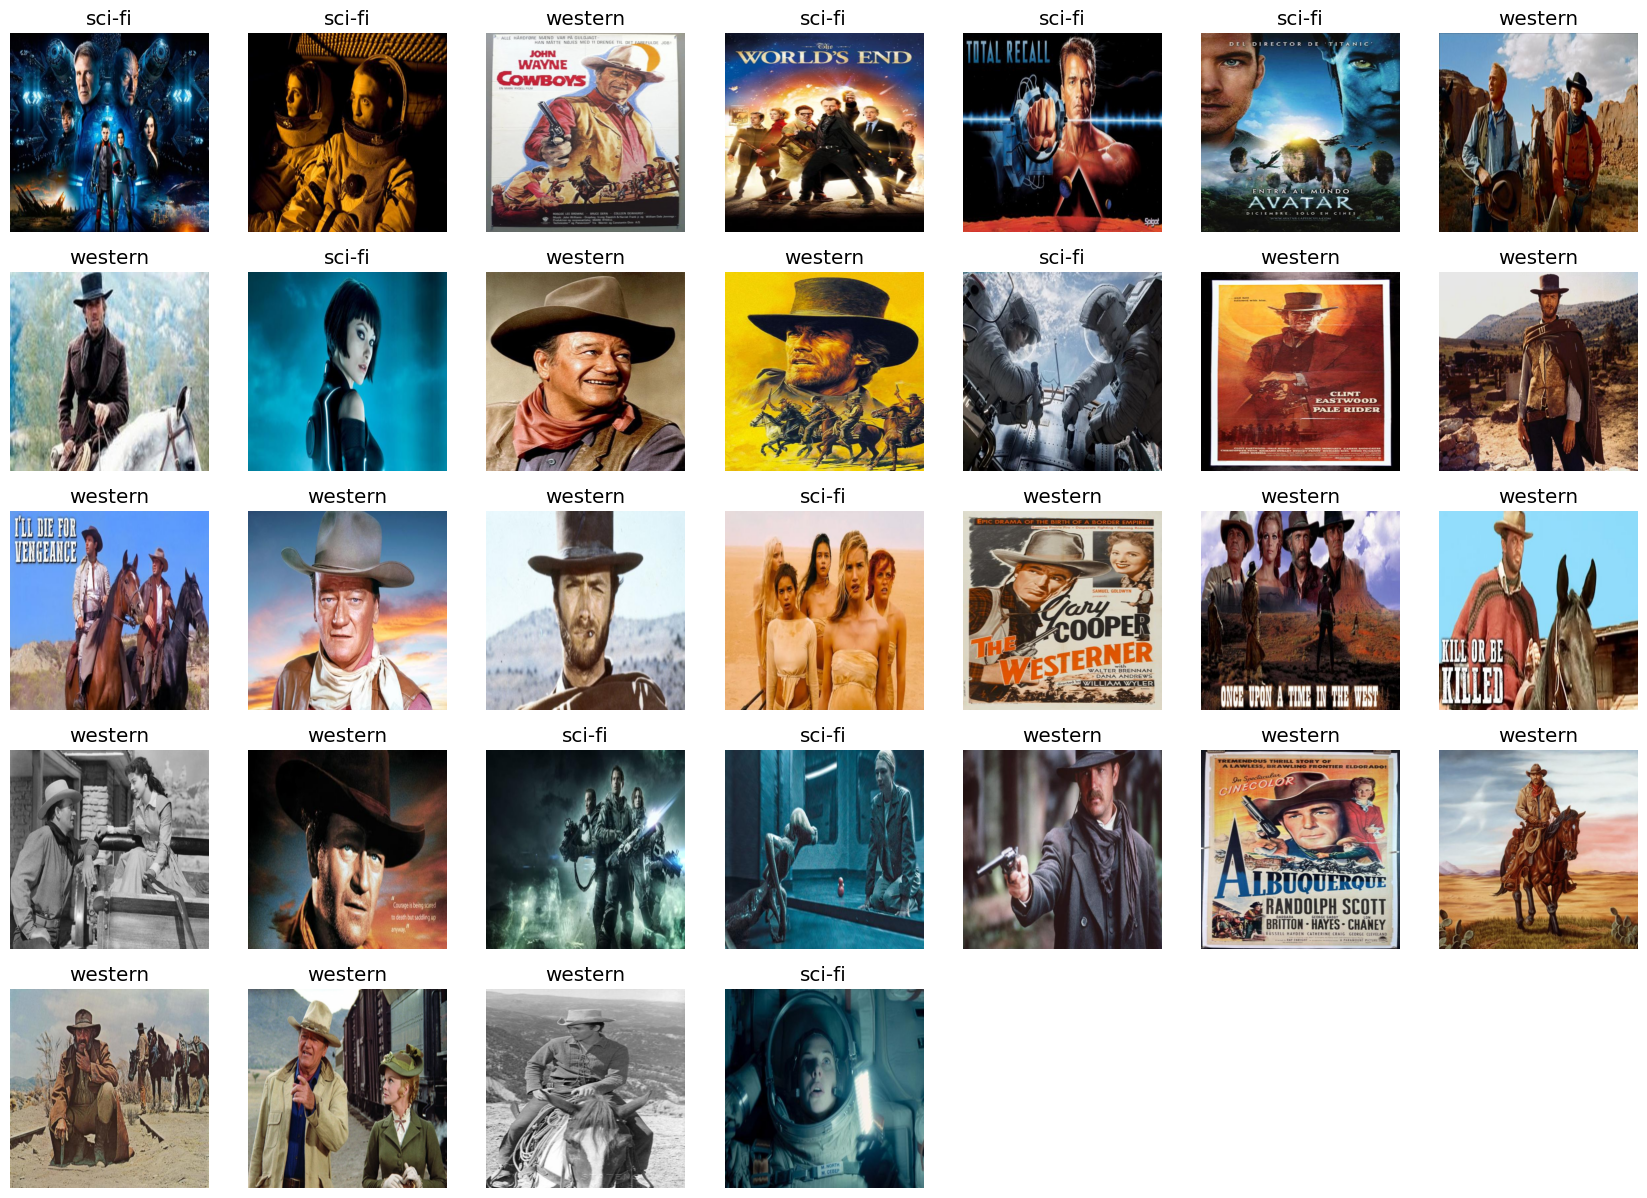

In [57]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(600, method='squish')]
).dataloaders(path, bs=32)
dls.show_batch(max_n=32)

And we're now ready to train our model. We'll fine-tune `resnet18`, the fastest widely used computer vision model.

> "Fine-tuning" a model means that we're starting with a model someone else has trained using some other dataset (called the *pretrained model*), and adjusting the weights a little bit so that the model learns to recognise your particular dataset. In this case, the pretrained model was trained to recognise photos in *imagenet*, and widely-used computer vision dataset with images covering 1000 categories) For details on fine-tuning and why it's important, check out the [free fast.ai course](https://course.fast.ai/).

In [58]:
learn = vision_learner(dls, resnet18, metrics=accuracy)
learn.fine_tune(3)

Most of the times you should get accuracy above 0.90.

## Step 3: Use our model
Let's try out our trained model on our hand-picked images.

In [59]:
def predict(image_name):
    category,_,probs = learn.predict(PILImage.create(image_name))
    print(f"This is a {category} movie.")
    print(f"Probability it's a scifi movie: {probs[0]:.4f}") 
    print(f"Probability it's a western movie: {probs[1]:.4f}") 

This is a sci-fi movie.
Probability it's a scifi movie: 0.8635
Probability it's a western movie: 0.1365


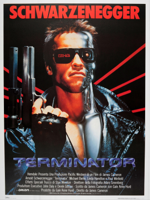

In [67]:
predict('test/terminator.jpg')
Image.open('test/terminator.jpg').to_thumb(200,200)

This is a western movie.
Probability it's a scifi movie: 0.0003
Probability it's a western movie: 0.9997


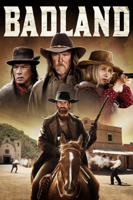

In [68]:
predict('test/badland.jpg')
Image.open('test/badland.jpg').to_thumb(200,200)

This is a western movie.
Probability it's a scifi movie: 0.0068
Probability it's a western movie: 0.9932


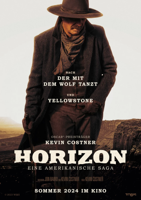

In [62]:
predict('test/horizon.jpg')
Image.open('test/horizon.jpg').to_thumb(200,200)

This is a western movie.
Probability it's a scifi movie: 0.2361
Probability it's a western movie: 0.7639


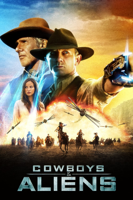

In [69]:
predict('test/cowboys_aliens.jpg')
Image.open('test/cowboys_aliens.jpg').to_thumb(200,200)

Huh? That's a tough one 🤔 I would go 50/50.

This is a western movie.
Probability it's a scifi movie: 0.0006
Probability it's a western movie: 0.9994


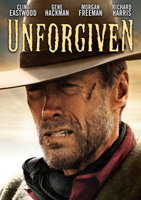

In [70]:
predict('test/unforgiven.jpg')
Image.open('test/unforgiven.jpg').to_thumb(200,200)

This is a sci-fi movie.
Probability it's a scifi movie: 0.8399
Probability it's a western movie: 0.1601


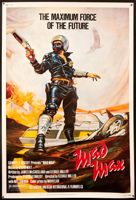

In [65]:
predict('test/mad-max.jpg')
Image.open('test/mad-max.jpg').to_thumb(200,200)

This one is not immediately obvious if you just glance at it.

This is a sci-fi movie.
Probability it's a scifi movie: 0.9820
Probability it's a western movie: 0.0180


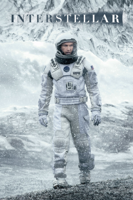

In [66]:
predict('test/interstellar.jpg')
Image.open('test/interstellar.jpg').to_thumb(200,200)

This one is an no-brainer.

I think overall the results are pretty good! Let's check the confusion matrix and top losses.

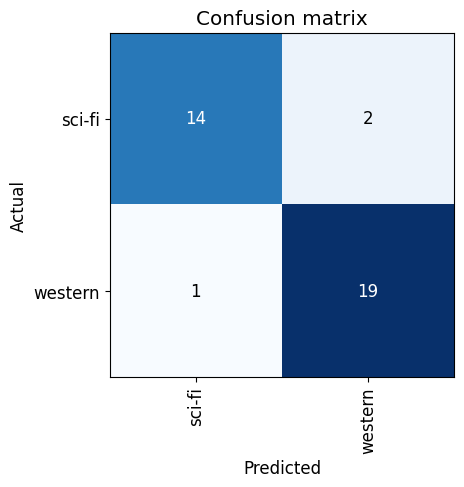

In [71]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

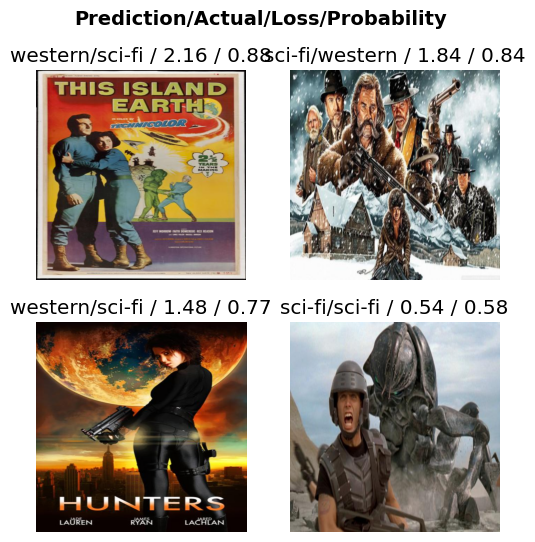

In [72]:
interp.plot_top_losses(4, nrows=2)

In [73]:
learn.export('model.pkl')